In [5]:
def create_global_dict(path):
    global_info_dict = {}
    with open(path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['redcap_event_name'][:5] == 'daily':
                break
            for key in row.keys():
                if key != 'subject_id' and key != 'redcap_event_name' and key != 'redcap_repeat_instrument' and row[key] != '':
                    global_info_dict[key] = row[key]
    return global_info_dict


In [6]:
def get_daily_info_dict(path):

    daily_info_dict = {}
    event_type = ['daily_checkin_timestamp', 'daily_check_in_date', 'synce_reminder', 'daily_feeling', 
                  'daily_distressed_level', 'daily_covid_contact', 'daily_covid_team_contact', 'daily_contact_in_rotation', 
                  'daily_anxious_level', 'daily_overall_anxiety', 'tag_event_0', 'daily_anxious_event',
                  'tag_event_1', 'daily_other_event_detail', 'daily_time_anxiety', 'daily_anxiety_recall', 'daily_anxiety_event',
                  'daily_checkin_complete']
    with open(path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['redcap_event_name'][:5] != 'daily':
                continue
            unique_id = row['redcap_event_name'] + '/' + row['redcap_repeat_instrument'] + '/instance' + row['redcap_repeat_instance']
            nested_d = {}
            counter = 0
            for key in row.keys():
                if (key[-9:] != 'timestamp' or row[key] == '') and counter == 0:
                    continue
                if counter == len(event_type):
                    break
                nested_d[event_type[counter]] = row[key]
                counter += 1
                
            daily_info_dict[unique_id] = nested_d
    return daily_info_dict
                
                

In [7]:
patients = ['4', '5', '7', '9', '12', '14']
all_d = {}
for patient in patients:
    patient_d = {}
    path = 'Participant_' + patient + '_RADWearStudy.csv'
    patient_d['global_info_dict'] = create_global_dict(path)
    patient_d['local_info_dict'] = get_daily_info_dict(path)
    all_d[patient] = patient_d
    

NameError: name 'csv' is not defined

In [1]:
import pickle
with open('all_dict.pkl', 'wb') as handle:
    pickle.dump(all_d, handle, protocol=pickle.HIGHEST_PROTOCOL)

NameError: name 'all_d' is not defined

In [8]:
import pickle
with open('all_dict.pkl', 'rb') as f:
    data = pickle.load(f)

In [53]:
import pandas as pd
all_participants_dict = pd.read_pickle('all_dict.pkl')
relevant_keys = ['daily_check_in_date', 'daily_feeling', 'daily_distressed_level', 'daily_anxious_level', 
                 'daily_overall_anxiety', 'daily_covid_contact', 'daily_covid_team_contact']
subject_labels = []
for key in all_participants_dict.keys():
    subject_data = []
    for instance in all_participants_dict[key]['local_info_dict'].keys():
        key_data = []
        for rel_key in relevant_keys:
            # Ensure that the relevant keys exist to avoid runtime error
            if len(all_participants_dict[key]['local_info_dict'][instance]) > 0:
                key_data.append(all_participants_dict[key]['local_info_dict'][instance][rel_key])
            else:
                break
        # Ensure that subject labels contain all the necessary information      
        if len(key_data) == len(relevant_keys):
            key_data.insert(0, key)
            subject_labels.append(key_data)
label_df = pd.DataFrame(subject_labels)
label_df.rename(columns={0:'daily_anxious_level', 1:'daily_check_in_date', 2:'subject',
                        3:'daily_overall_anxiety', 4:'daily_distressed_level', 5:'daily_feeling',
                        6:'daily_covid_contact', 7:'daily_covid_team_contact'}, inplace=True)

In [54]:
label_df

,daily_anxious_level,daily_check_in_date,subject,daily_overall_anxiety,daily_distressed_level,daily_feeling,daily_covid_contact,daily_covid_team_contact
0,5,2022-06-27,3,6,1,2,2,2
1,5,2022-06-28,4,5,1,3,2,2
2,5,2022-06-29,5,2,2,3,2,2
3,5,2022-06-30,5,7,2,7,2,2
4,5,2022-07-01,8,2,3,2,2,2
...,...,...,...,...,...,...,...,...
73,14,2022-07-22,7,1,1,1,2,2
74,14,2022-07-26,8,2,2,3,2,2
75,14,2022-07-27,8,1,1,1,2,2
76,14,2022-07-28,9,1,1,2,2,2


In [60]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.signal import correlate
# Include Covid-19 contact
attributes = ['daily_anxious_level', 'daily_overall_anxiety', 'daily_distressed_level', 'daily_feeling','daily_covid_contact', 'daily_covid_team_contact']
label_df.loc[label_df['daily_covid_team_contact'] == ''] = '0'
label_df[attributes] = label_df[attributes].astype(int)
np_label = np.array(label_df[attributes])

In [61]:
label_df

,daily_anxious_level,daily_check_in_date,subject,daily_overall_anxiety,daily_distressed_level,daily_feeling,daily_covid_contact,daily_covid_team_contact
0,5,2022-06-27,3,6,1,2,2,2
1,5,2022-06-28,4,5,1,3,2,2
2,5,2022-06-29,5,2,2,3,2,2
3,5,2022-06-30,5,7,2,7,2,2
4,5,2022-07-01,8,2,3,2,2,2
...,...,...,...,...,...,...,...,...
73,14,2022-07-22,7,1,1,1,2,2
74,14,2022-07-26,8,2,2,3,2,2
75,14,2022-07-27,8,1,1,1,2,2
76,14,2022-07-28,9,1,1,2,2,2


In [62]:
import matplotlib.pyplot as plt
def visualize_kmeans(data, dim1, dim2):
    kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
    kmeans.fit(data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    #plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
    plt.scatter(data[:, 0], data[:, 1])
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        "K-means clustering for " + dim1 + ' vs ' + dim2 + "\n"
        "Centroids are marked with white cross"
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(range(int(x_min), int(x_max+1), 2), range(int(x_min),int(x_max+1), 2))
    plt.yticks(range(int(y_min), int(y_max+1), 2), range(int(y_min),int(y_max+1), 2))
    plt.show()

In [63]:
for i in range(len(attributes)):
    for j in range(i+1, len(attributes)):
        print('correlation between {} and {} is {}'.format(attributes[i], attributes[j], label_df[attributes[i]].corr(label_df[attributes[j]])))

correlation between daily_anxious_level and daily_overall_anxiety is -0.22878338984278115
correlation between daily_anxious_level and daily_distressed_level is 0.1637028159976259
correlation between daily_anxious_level and daily_feeling is -0.24407829883166407
correlation between daily_anxious_level and daily_covid_contact is 0.2548537671609826
correlation between daily_anxious_level and daily_covid_team_contact is 0.2488400660749524
correlation between daily_overall_anxiety and daily_distressed_level is 0.544952026340942
correlation between daily_overall_anxiety and daily_feeling is 0.8353468208181755
correlation between daily_overall_anxiety and daily_covid_contact is 0.0558718800104004
correlation between daily_overall_anxiety and daily_covid_team_contact is 0.08654265260082532
correlation between daily_distressed_level and daily_feeling is 0.6000026213520285
correlation between daily_distressed_level and daily_covid_contact is 0.18281978931420834
correlation between daily_distresse

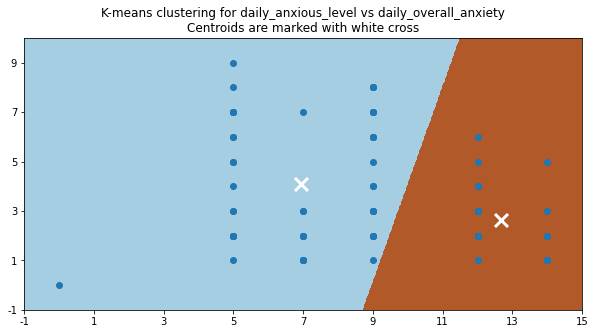

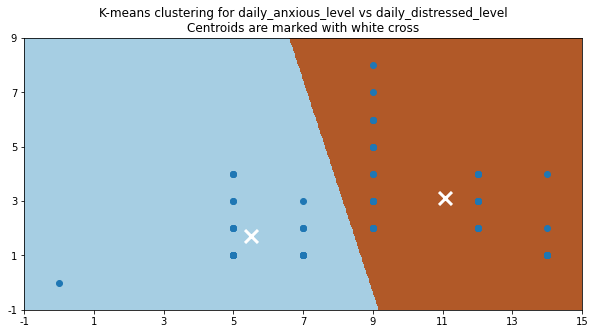

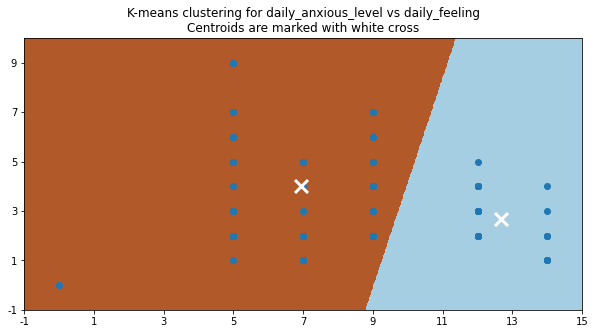

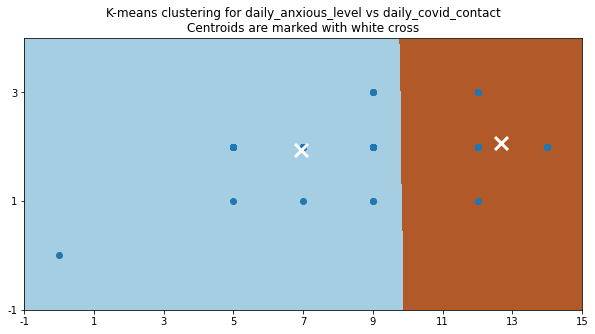

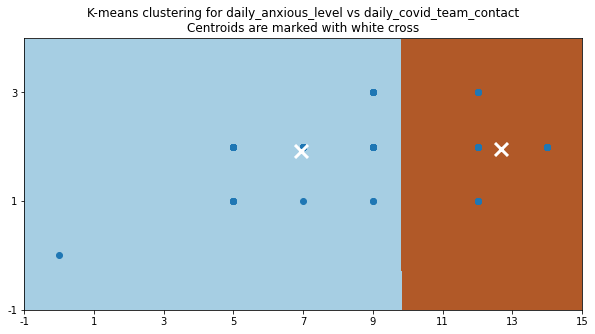

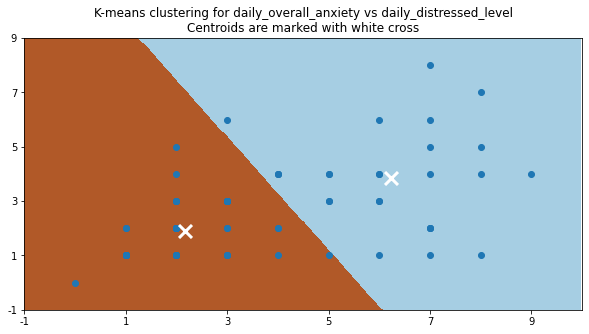

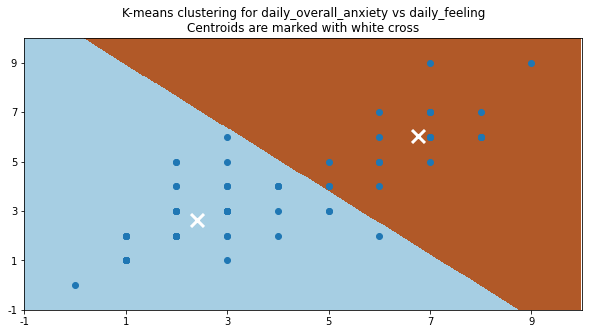

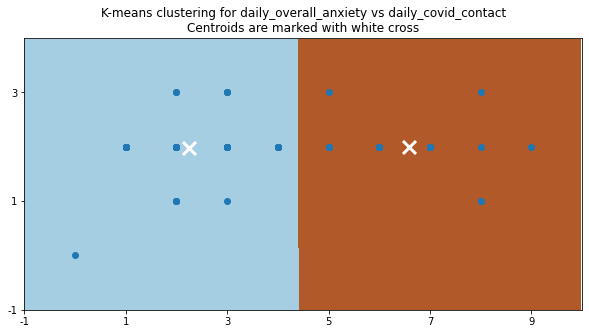

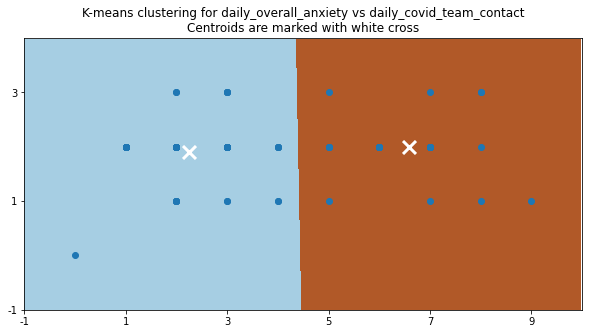

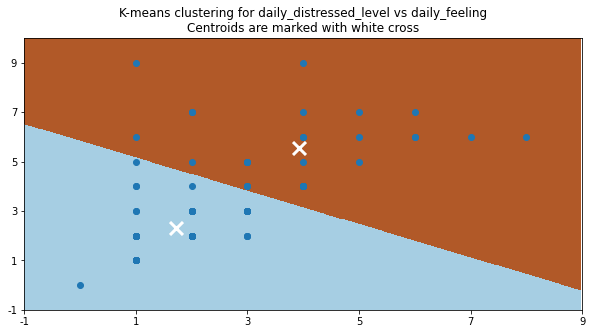

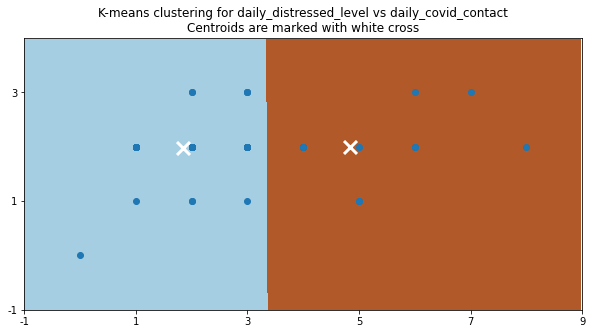

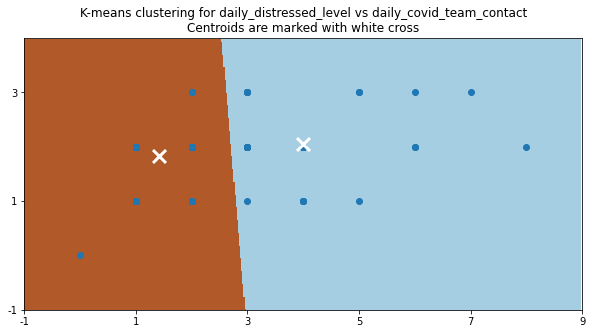

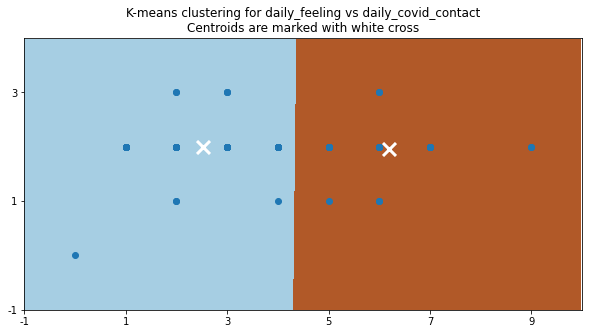

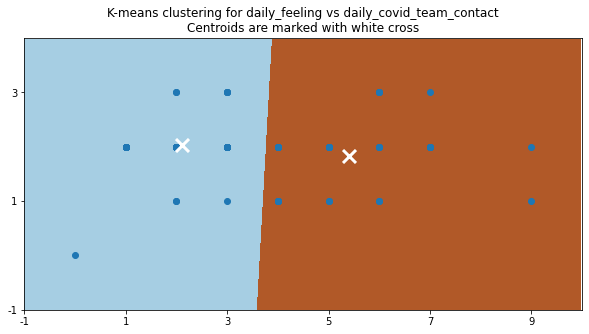

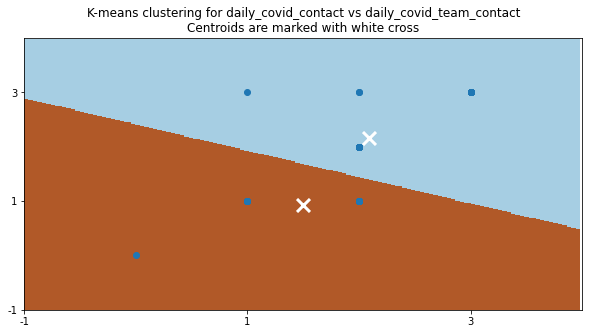

In [64]:
for i in range(len(attributes)):
    for j in range(i+1, len(attributes)):
        plt.figure(figsize=(10, 5))
        visualize_kmeans(np_label[:, [i, j]], attributes[i], attributes[j])

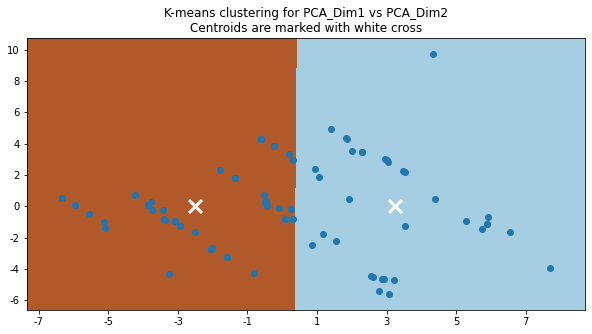

In [65]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(np_label)
plt.figure(figsize=(10, 5))
visualize_kmeans(reduced_data, 'PCA_Dim1', 'PCA_Dim2')